
# Лабораторная работа 2. Регрессия, мультиколлинеарность, множественные сравнения, байесовские выводы и ресемплинг

**Курс:** Прикладная статистика и анализ данных

**Раздел 2:** Статистическое моделирование, гипотезы и интерпретация    

**Цель:** построить и сравнить несколько спецификаций множественной линейной регрессии, диагностировать мультиколлинеарность и применить регуляризацию; корректно проверять семейства гипотез (контрасты/коэффициенты) с контролем FDR; провести байесовскую регрессию с априорами и постериорной проверкой предсказаний; оценить доверие к выводам с помощью бутстрепа и перестановочных тестов.

**Ожидаемые результаты:** уметь (1) задавать и интерпретировать линейные модели с взаимодействиями; (2) диагностировать и снижать мультиколлинеарность (VIF, Ridge/Lasso с подбором $\lambda$ по CV); (3) применять FDR-контроль к семействам проверок; (4) формулировать априоры и читать апостериор (PyMC), выполнять PPC; (5) строить бутстреп-ДИ и перестановочные p-значения; (6) оформлять воспроизводимый отчёт.



## 1. Данные и дизайн эксперимента

Требования к данным. Желательно $n\in[5\cdot10^4,1.5\cdot10^5]$, смешанные типы (число+категории+время). Разрешены большие наборы с честной подвыборкой (например, фиксированный интервал времени/случайная выборка 100–120 тыс. строк). Хорошими источниками являются городские такси (NYC TLC, Chicago Taxi), e-commerce (Olist), поведенческие/рейтинговые (MovieLens), дорожно-транспортные происшествия (STATS19).

Вопросы и переменные. Определите: целевую переменную $y$ (непрерывную: выручка/длительность/сумма), набор предикторов $X$ (стоимость, время суток, категория товара, погодные/районные признаки), потенциальные взаимодействия (например, «час$\times$район»). Разбейте данные на обучающую/валидационную схему с кросс-валидацией. Для задач на транзакциях важно исключить утечки (например, признаки, формирующиеся пост-фактум).

Критерии качества и риска. Выберите метрики: $R^2$, RMSE/MAE для базовой модели; для сравнения моделей используйте перекрёстную проверку (KFold/StratifiedKFold, при необходимости — TimeSeriesSplit). Фиксируйте случайные зерна и протоколы предобработки.


## 2. Линейные модели и ANOVA: спецификация и сравнение (минимум 600 слов)

OLS-модель. Запишите базовую спецификацию: $y = X\beta+\varepsilon$, где $\varepsilon\sim \mathcal{N}(0,\sigma^2 I)$. Оценка МНК: $\hat\beta=(X^\top X)^{-1}X^\top y$. Включите категориальные эффекты (OHE) и взаимодействия (например, «категория$\times$час»). Сравните вложенные модели через частичные F-тесты/девиансы.

ANOVA/контрасты. Для сравнения спецификаций используйте дисперсионный анализ в смысле разложения суммы квадратов и тестирования добавочных блоков признаков. Вектор контраста $c$ для проверки гипотезы $H_0: c^\top\beta=0$; оценка и стандартная ошибка выводятся из ковариационной матрицы $\widehat{\mathrm{Var}}(\hat\beta)=\hat\sigma^2 (X^\top X)^{-1}$.

Множественные проверки. При тестировании множества коэффициентов/контрастов применяйте контроль FDR (Benjamini–Hochberg): упорядочьте p-значения $p_{(1)}\le\cdots\le p_{(m)}$ и найдите максимальный $k$ с $p_{(k)}\le \frac{k}{m}\alpha$; значимыми считаются $p_{(1)},\dots,p_{(k)}$. Реализация — statsmodels.stats.multitest.multipletests.

## 3. Мультиколлинеарность, VIF и регуляризация (минимум 600 слов)

Диагностика. Индекс инфляции дисперсии для признака $j$: $VIF_j=\frac{1}{1-R_j^2}$, где $R_j^2$ — коэффициент детерминации регрессии $x_j$ на все прочие признаки. Большие $VIF$ (условно $>10$) указывают на нестабильность оценок и раздутые стандартные ошибки.
Ridge/Lasso. Регуляризованные оценки:
- Ridge: $\hat\beta_\lambda=\arg\min_\beta |y-X\beta|_2^2 + \lambda|\beta|_2^2$,
- Lasso: $\hat\beta_\lambda=\arg\min_\beta |y-X\beta|_2^2 + \lambda|\beta|_1$.
Подбирайте $\lambda$ по кросс-валидации (например, лог-сетка). Ridge снижает дисперсию оценок и стабилизирует прогнозы при умеренной корреляции; Lasso даёт разреженность и встроенный отбор признаков, но чувствителен к масштабированию. См. документы и примеры scikit-learn по OLS/Ridge и обобщениям.

## 4. Байесовская регрессия и постериорно-предсказательная проверка

Модель. Пусть $y\mid X,\beta,\sigma^2\sim \mathcal{N}(X\beta,\sigma^2 I)$, априорные распределения $p(\beta)$ и $p(\sigma^2)$ (например, $\beta\sim \mathcal{N}(0,\tau^2 I)$; $\sigma\sim \mathrm{HalfCauchy}$). Постериор: $p(\beta,\sigma^2\mid y)\propto p(y\mid X,\beta,\sigma^2),p(\beta),p(\sigma^2)$. Предсказательное распределение для нового $x_\star$: $p(y_\star\mid x_\star,y)=\int p(y_\star\mid x_\star,\beta,\sigma^2),p(\beta,\sigma^2\mid y),d\beta,d\sigma^2$.

Практика. В PyMC укажите модель в явном виде, используйте NUTS для сэмплинга, проверьте сходимость (R-hat, ESS), постериорные интервалые для коэффициентов и PPC для согласованности с наблюдаемыми данными.

## 5. Ресемплинг: бутстреп-ДИ и перестановочные тесты

Бутстреп. Для параметра $\theta=g(X,y)$ (например, коэффициента $\beta_j$ или RMSE) сформируйте $B$ бутстреп-выборок с возвращением, получите ${\hat\theta^{(b)}}{b=1}^B$, и задайте ДИ по процентилям: $[q{\alpha/2},q_{1-\alpha/2}]$.

Перестановочные тесты. Для статистики $T$ (например, корреляция/разность RMSE между моделями на одинаковых фолдах) переставляйте метки/знаки по нулевой гипотезе, получая ${T^{(b)}}$, и вычисляйте $p$-значение $p=\frac{1+\sum_{b=1}^B \mathbb{I}(|T^{(b)}|\ge |T_{\text{obs}}|)}{1+B}$. Эти процедуры особенно полезны при нарушениях гауссовости/гомоскедастичности либо сложной зависимой структуре данных.

## Пул рекомендованных датасетов

D1. NYC TLC Trip Records (Yellow/Green). Возьмите один месяц и случайную подвыборку 100–120k поездок (например, январь 2019). Документация и структура полей — в руководстве TLC.

D2. Chicago Taxi Trips. Фильтрация по кварталу 2020-го даёт нужный объём; таблица содержит стоимость, время, гео-идентификаторы.

D3. Olist Brazilian E-commerce. Таблица orders $\approx 99,441$ заказов + связи с продуктами/категориями/логистикой. Отлично подходит для регрессии по выручке/времени доставки.

D4. MovieLens 100K. 100k рейтингов с признаками пользователей/фильмов; можно строить регрессию по рейтингу, учитывая жанры и время.

D5. UK Road Safety (STATS19). Выберите один год (например, 2017) и сформируйте подмножество ≈100–140k инцидентов, обогащая погодой/дорожными условиями.

## 35 вариантов заданий (обобщающие, с привязкой к D1–D5)
### Общие методические требования (для всех вариантов):
1) Постройте базовую OLS-модель (целевую переменную укажу в каждом варианте).
2) Выполните диагностику мультиколлинеарности (VIF) и сравните с Ridge/Lasso (подбор $\lambda$ по $K$-fold CV).
3) Проведите проверки гипотез по коэффициентам/контрастам; множественные сравнения контролируйте по BH-FDR.
4) Постройте байесовскую версию ключевой модели с умеренно информативными априорами и выполните предиктивную проверку (PPC).
5) Оцените устойчивость: бутстреп-ДИ для ключевого показателя (RMSE/MAE/$R^2$) и перестановочный тест для сопоставления двух моделей.
6) Объём данных: используйте подвыборку 50–150 тыс. строк из указанного источника, обоснуйте схему семплинга (по месяцам/зонам/времени и т. п.).

MovieLens-Rating (D4). Цель: предсказать rating. Признаки: жанровые фиктивные переменные (из movies.csv), средний рейтинг фильма (leave-one-out), активность пользователя (кол-во оценок; LOO), временной тренд по году. Сравните OLS vs. Ridge; выполните BH-FDR по семейству жанров. Бутстреп-ДИ для $R^2$; перестановка для разницы RMSE между OLS/Ridge; байес-версия с частичным пуллингом по фильмам/пользователям (иерархичность).

## Подготовка данных

In [1]:
# Импорты и фиксируем зерно случайности для воспроизводимости
import os
import sys
import math
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime

from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Убедимся, что рабочая директория — папка с ноутбуком
print("CWD =", os.getcwd())


CWD = C:\Users\batar\Python\Applied_statistics_master_degree\Lab_2


In [2]:
data_dir = Path("ml-100k")

path_ratings = data_dir / "u.data"
path_items   = data_dir / "u.item"
path_users   = data_dir / "u.user"   

# Загрузка
ratings = pd.read_csv(
    path_ratings, sep="\t", header=None,
    names=["user_id", "movie_id", "rating", "timestamp"]
)

items = pd.read_csv(
    path_items, sep="|", header=None, encoding="latin-1",
    names=[
        "movie_id","title","release_date","video_release","imdb_url",
        "unknown","Action","Adventure","Animation","Children's","Comedy","Crime",
        "Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery",
        "Romance","Sci-Fi","Thriller","War","Western"
    ]
)

print(ratings.shape, items.shape)
ratings.head(), items.head(2)


(100000, 4) (1682, 24)


(   user_id  movie_id  rating  timestamp
 0      196       242       3  881250949
 1      186       302       3  891717742
 2       22       377       1  878887116
 3      244        51       2  880606923
 4      166       346       1  886397596,
    movie_id             title release_date  video_release  \
 0         1  Toy Story (1995)  01-Jan-1995            NaN   
 1         2  GoldenEye (1995)  01-Jan-1995            NaN   
 
                                             imdb_url  unknown  Action  \
 0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
 1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
 
    Adventure  Animation  Children's  ...  Fantasy  Film-Noir  Horror  Musical  \
 0          0          1           1  ...        0          0       0        0   
 1          1          0           0  ...        0          0       0        0   
 
    Mystery  Romance  Sci-Fi  Thriller  War  Western  
 0        0        0       0         0

In [3]:
# Парсим год релиза из строки "dd-Mmm-YYYY", иногда есть пропуски
def parse_year_from_date(s):
    if isinstance(s, str) and len(s) >= 4:
        try:
            return int(s[-4:])
        except Exception:
            return np.nan
    return np.nan

items["year_release"] = items["release_date"].apply(parse_year_from_date)
genre_cols = [
    "unknown","Action","Adventure","Animation","Children's","Comedy","Crime",
    "Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery",
    "Romance","Sci-Fi","Thriller","War","Western"
]

# Превратим timestamp оценок в календарный год — это "временной тренд по году" с точки зрения момента оценки
ratings["dt"] = pd.to_datetime(ratings["timestamp"], unit="s", utc=True)
ratings["year_rate"] = ratings["dt"].dt.year.astype(int)

# Склеиваем
df = ratings.merge(
    items[["movie_id", "year_release"] + genre_cols],
    on="movie_id", how="left"
)

# Обработка пропусков года релиза (редки): заменим на медиану
df["year_release"] = df["year_release"].fillna(df["year_release"].median())

# Центрирование временных признаков (ортогонализует сдвиг)
df["year_release_c"] = df["year_release"] - df["year_release"].mean()
df["year_rate_c"]    = df["year_rate"]    - df["year_rate"].mean()

# Контроль размера и базовые sanity-checks
print("Rows:", len(df))
print("Users:", df["user_id"].nunique(), "Movies:", df["movie_id"].nunique())
print("Years (rate):", df["year_rate"].min(), "–", df["year_rate"].max())
df.head()


Rows: 100000
Users: 943 Movies: 1682
Years (rate): 1997 – 1998


,user_id,movie_id,rating,timestamp,dt,year_rate,year_release,unknown,Action,Adventure,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year_release_c,year_rate_c
0,196,242,3,881250949,1997-12-04 15:55:49+00:00,1997,1997.0,0,0,0,...,0,0,0,0,0,0,0,0,9.04324,-0.47101
1,186,302,3,891717742,1998-04-04 19:22:22+00:00,1998,1997.0,0,0,0,...,0,0,1,0,0,1,0,0,9.04324,0.52899
2,22,377,1,878887116,1997-11-07 07:18:36+00:00,1997,1994.0,0,0,0,...,0,0,0,0,0,0,0,0,6.04324,-0.47101
3,244,51,2,880606923,1997-11-27 05:02:03+00:00,1997,1994.0,0,0,0,...,0,0,0,1,0,0,1,1,6.04324,-0.47101
4,166,346,1,886397596,1998-02-02 05:33:16+00:00,1998,1997.0,0,0,0,...,0,0,0,0,0,0,0,0,9.04324,0.52899


In [4]:
# Целевая переменная
y_col = "rating"

# Базовые предикторы: жанры + временные тренды
# (LOO-признаки добавим позже в разделе фичеинжиниринга, чтобы не допустить утечек)
base_feature_cols = genre_cols + ["year_release_c", "year_rate_c"]

# Пример потенциальных взаимодействий для следующих пунктов (сейчас только объявляем):
# - Жанр × год оценки (динамика восприятия жанра)
# - Жанр × год релиза (устаревание эффекта)
# Эти взаимодействия создадим позже осознанно, когда будем смотреть VIF/регуляризацию.
potential_interactions = {
    "genre_x_year_rate": [("year_rate_c", g) for g in genre_cols],
    "genre_x_year_release": [("year_release_c", g) for g in genre_cols],
}

print("Target:", y_col)
print("Base features (count):", len(base_feature_cols))
base_feature_cols[:8], "...", base_feature_cols[-5:]


Target: rating
Base features (count): 21


(['unknown',
  'Action',
  'Adventure',
  'Animation',
  "Children's",
  'Comedy',
  'Crime',
  'Documentary'],
 '...',
 ['Thriller', 'War', 'Western', 'year_release_c', 'year_rate_c'])

In [5]:
# Для рейтингов критично: пользовательские паттерны.
# Чтобы не «подсматривать» индивидуальные эффекты, держим пользователей разнесёнными по фолдам.
# Это снижает optimistic bias и имитирует генерализацию на новых пользователей.

n_splits = 5
cv_splitter = GroupKFold(n_splits=n_splits)
cv_groups = df["user_id"].values  # группы = пользователи

# Пример: посчитаем размер фолдов (без обучения — просто дизайн)
fold_sizes = []
for fold_id, (_, te_idx) in enumerate(cv_splitter.split(df, groups=cv_groups), 1):
    fold_sizes.append(len(te_idx))
    print(f"Fold {fold_id}: test size = {len(te_idx)}")

print("Sum test sizes =", sum(fold_sizes), "==", len(df))


Fold 1: test size = 20008
Fold 2: test size = 20008
Fold 3: test size = 20008
Fold 4: test size = 19988
Fold 5: test size = 19988
Sum test sizes = 100000 == 100000


In [6]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

metrics = {
    "RMSE": rmse,
    "MAE": mae,
    "R2": r2
}

print("Метрики готовы:", list(metrics.keys()))
print("Random state =", RANDOM_STATE)


Метрики готовы: ['RMSE', 'MAE', 'R2']
Random state = 42


In [7]:
# На этом шаге мы НЕ создаём LOO-признаки, чтобы не спутать дизайн и вычисления.
# Здесь — только базовый X для первичной диагностики и профилирования распределений.

X_base = df[base_feature_cols].astype(float).copy()
y = df[y_col].astype(float).values

print("X_base shape:", X_base.shape, "y shape:", y.shape)
print("Пример жанровых частот:")
df[genre_cols].mean().sort_values(ascending=False).head(10)


X_base shape: (100000, 21) y shape: (100000,)
Пример жанровых частот:


Drama         0.39895
Comedy        0.29832
Action        0.25589
Thriller      0.21872
Romance       0.19461
Adventure     0.13753
Sci-Fi        0.12730
War           0.09398
Crime         0.08055
Children's    0.07182
dtype: float64

In [8]:
n = len(df)
n_users = df["user_id"].nunique()
n_movies = df["movie_id"].nunique()

assert 50_000 <= n <= 150_000, "Размер данных не попадает в требуемый диапазон."
print(f"OK: n={n} в требуемом диапазоне [50k, 150k]. Users={n_users}, Movies={n_movies}")

# Смешанные типы подтверждаем:
has_numeric = True
has_categorical_like = len(genre_cols) > 0
has_temporal = True  # есть year_rate и year_release
print(f"Типы: numeric={has_numeric}, categorical(one-hot)={has_categorical_like}, temporal={has_temporal}")


OK: n=100000 в требуемом диапазоне [50k, 150k]. Users=943, Movies=1682
Типы: numeric=True, categorical(one-hot)=True, temporal=True


In [9]:
df.head(5)

,user_id,movie_id,rating,timestamp,dt,year_rate,year_release,unknown,Action,Adventure,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year_release_c,year_rate_c
0,196,242,3,881250949,1997-12-04 15:55:49+00:00,1997,1997.0,0,0,0,...,0,0,0,0,0,0,0,0,9.04324,-0.47101
1,186,302,3,891717742,1998-04-04 19:22:22+00:00,1998,1997.0,0,0,0,...,0,0,1,0,0,1,0,0,9.04324,0.52899
2,22,377,1,878887116,1997-11-07 07:18:36+00:00,1997,1994.0,0,0,0,...,0,0,0,0,0,0,0,0,6.04324,-0.47101
3,244,51,2,880606923,1997-11-27 05:02:03+00:00,1997,1994.0,0,0,0,...,0,0,0,1,0,0,1,1,6.04324,-0.47101
4,166,346,1,886397596,1998-02-02 05:33:16+00:00,1998,1997.0,0,0,0,...,0,0,0,0,0,0,0,0,9.04324,0.52899


In [53]:
def make_oof_loo_features(df: pd.DataFrame, n_splits: int = 5, random_state: int = 42):
    """
    Делает out-of-fold LOO-признаки:
    - movie_mean_loo_oof: для train строк = (sum_movie - r)/ (cnt_movie - 1);
                           для test строк = mean_movie по train-фолду;
                           холодный фильм → глобальное среднее train.
    - user_count_loo_oof: для train строк = (cnt_user - 1);
                           для test строк = cnt_user в train-фолде (0 если холодный).
    Разбиение по пользователю (GroupKFold), чтобы не «подсматривать» личные паттерны.
    """
    df = df.copy()
    df["movie_mean_loo_oof"] = np.nan
    df["user_count_loo_oof"] = np.nan

    gkf = GroupKFold(n_splits=n_splits)
    groups = df["user_id"].values
    y = df["rating"].values

    global_mean = df["rating"].mean()

    for fold_id, (tr_idx, te_idx) in enumerate(gkf.split(df, groups=groups), 1):
        tr = df.iloc[tr_idx]
        te = df.iloc[te_idx]

        # агрегаты по фильму на train
        m_sum = tr.groupby("movie_id")["rating"].sum()
        m_cnt = tr.groupby("movie_id")["rating"].count()
        m_mean = m_sum / m_cnt

        # агрегаты по пользователю на train
        u_cnt = tr.groupby("user_id")["rating"].count()

        # ----- train части (истинный LOO)
        tr_movie_sum = df.loc[tr_idx].groupby("movie_id")["rating"].transform("sum")
        tr_movie_cnt = df.loc[tr_idx].groupby("movie_id")["rating"].transform("count")
        # (sum - r)/(cnt - 1); защитимся от деления на ноль
        tr_loo = (tr_movie_sum - y[tr_idx]) / np.clip(tr_movie_cnt - 1, 1, None)

        tr_user_cnt = df.loc[tr_idx].groupby("user_id")["rating"].transform("count")
        tr_user_loo = tr_user_cnt - 1

        df.loc[df.index[tr_idx], "movie_mean_loo_oof"] = tr_loo
        df.loc[df.index[tr_idx], "user_count_loo_oof"] = tr_user_loo

        # ----- test части (только train-информация)
        # фильм может отсутствовать в train → подставим глобальное среднее
        te_movie_mean = te["movie_id"].map(m_mean).fillna(global_mean).values
        # активность пользователя в train (может быть 0)
        te_user_cnt = te["user_id"].map(u_cnt).fillna(0).values

        df.loc[df.index[te_idx], "movie_mean_loo_oof"] = te_movie_mean
        df.loc[df.index[te_idx], "user_count_loo_oof"] = te_user_cnt

    # sanity
    assert not df["movie_mean_loo_oof"].isna().any()
    assert not df["user_count_loo_oof"].isna().any()
    return df


In [54]:
# строим ровно нужные по заданию признаки
df_loo = make_oof_loo_features(df, n_splits=5)

# финальная матрица X: жанры + LOO + тренд по году оценки
final_feature_cols = genre_cols + ["movie_mean_loo_oof", "user_count_loo_oof", "year_rate_c"]
X_final = df_loo[final_feature_cols].astype(float).copy()
y_final = df_loo["rating"].astype(float).values

print("X_final shape:", X_final.shape)
X_final.head()

X_final shape: (100000, 22)


,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_mean_loo_oof,user_count_loo_oof,year_rate_c
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.022222,0.0,-0.47101
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.230088,91.0,0.52899
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.500000,0.0,-0.47101
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.459016,237.0,-0.47101
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.625000,19.0,0.52899


## OLS МОДЕЛИ И ANOVA

In [17]:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
from typing import Dict, List, Optional

from scipy.stats import f as f_dist
from scipy.stats import t as t_dist

In [24]:
# =============================================================================
# OLS МОДЕЛИ И ANOVA
# =============================================================================

def fit_ols_model(
    X: pd.DataFrame,
    y: np.ndarray,
    add_constant: bool = True
) -> sm.regression.linear_model.RegressionResultsWrapper:
    """
    Построить OLS модель

    Parameters
    ----------
    X : pd.DataFrame
        Матрица признаков
    y : np.ndarray
        Целевая переменная
    add_constant : bool
        Добавить константу

    Returns
    -------
    statsmodels RegressionResults
        Результаты регрессии
    """
    X_proc = sm.add_constant(X) if add_constant else X
    model = sm.OLS(y, X_proc).fit()
    print(model.summary())
    return model


def compare_nested_models(
    model_restricted: sm.regression.linear_model.RegressionResultsWrapper,
    model_full: sm.regression.linear_model.RegressionResultsWrapper,
    alpha: float = 0.05
) -> Dict[str, float]:
    """
    Сравнить вложенные модели через F-тест (partial F).
    """
    rss_r = np.sum(model_restricted.resid ** 2)
    rss_f = np.sum(model_full.resid ** 2)
    df_r = int(model_restricted.df_resid)
    df_f = int(model_full.df_resid)

    # Защита от перепутанных моделей
    if df_r <= df_f:
        raise ValueError("Ограниченная модель должна иметь МЕНЬШЕ параметров (больше df_resid), чем полная.")

    num_df = df_r - df_f          # Δdf
    den_df = df_f                 # df_full
    F_stat = ((rss_r - rss_f) / num_df) / (rss_f / den_df)
    p_val = f_dist.sf(F_stat, num_df, den_df)

    conclusion = "Reject H0 (полная лучше)" if p_val < alpha else "Fail to reject H0"
    print(f"Partial F: F({num_df}, {den_df}) = {F_stat:.4f}, p = {p_val:.4g} -> {conclusion}")

    return {"F": F_stat, "p_value": p_val, "num_df": num_df, "den_df": den_df, "conclusion": conclusion}



def test_linear_contrasts(
    model: sm.regression.linear_model.RegressionResultsWrapper,
    contrast_matrix: np.ndarray,
    contrast_names: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Проверить линейные контрасты c^T β = 0 для OLS-модели.
    """
    cov_beta = model.cov_params().values
    beta_hat = model.params.values
    df_resid = int(model.df_resid)

    results = []
    for i, c in enumerate(np.atleast_2d(contrast_matrix)):
        c = np.asarray(c).reshape(-1)
        est = float(c @ beta_hat)
        se2 = float(c @ cov_beta @ c)
        se = math.sqrt(se2) if se2 > 0 else float("nan")
        t_stat = est / se
        p_val = 2 * t_dist.sf(abs(t_stat), df_resid)
        results.append({
            "contrast": (contrast_names[i] if contrast_names else f"c{i+1}"),
            "estimate": est,
            "SE": se,
            "t": t_stat,
            "p_value": p_val,
            "df": df_resid
        })
    return pd.DataFrame(results)



from scipy.stats import f as f_dist
import pandas as pd
import numpy as np
import statsmodels.api as sm


def compute_anova_table(
    model_restricted: sm.regression.linear_model.RegressionResultsWrapper,
    model_full: sm.regression.linear_model.RegressionResultsWrapper,
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Вычислить таблицу ANOVA (Type I) для сравнения вложенных моделей.

    """
    # Проверки вложенности
    df_r = int(model_restricted.df_resid)
    df_f = int(model_full.df_resid)
    if df_r <= df_f:
        raise ValueError(
            "Restricted model должна иметь МЕНЬШЕ параметров "
            "(больше df_resid), чем full."
        )

    # Суммы квадратов остатков
    rss_r = float(np.sum(model_restricted.resid ** 2))
    rss_f = float(np.sum(model_full.resid ** 2))

    # Разности
    ss_diff = rss_r - rss_f
    df_diff = df_r - df_f
    ms_diff = ss_diff / df_diff
    ms_full = rss_f / df_f

    # F и p
    F_stat = ms_diff / ms_full
    p_val = f_dist.sf(F_stat, df_diff, df_f)
    significant = p_val < alpha

    table = pd.DataFrame({
        "Model": ["Restricted", "Full", "Difference"],
        "SS": [rss_r, rss_f, ss_diff],
        "df": [df_r, df_f, df_diff],
        "MS": [rss_r / df_r, rss_f / df_f, ms_diff],
        "F": [np.nan, np.nan, F_stat],
        "p_value": [np.nan, np.nan, p_val],
        "Significant": [np.nan, np.nan, significant]
    })

    print(
        f"ANOVA Type I: ΔSS={ss_diff:.3f}, Δdf={df_diff}, "
        f"F={F_stat:.3f}, p={p_val:.4g} → "
        f"{'Reject H0' if significant else 'Fail to reject H0'}"
    )

    return table



In [55]:
model_restricted = fit_ols_model(X_final, y_final)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     966.2
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:21:05   Log-Likelihood:            -1.4409e+05
No. Observations:              100000   AIC:                         2.882e+05
Df Residuals:                   99977   BIC:                         2.885e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5956      0

In [56]:
# Взаимодействия "жанр × год оценки" на новой матрице (df_loo)
inter_cols = []
for g in genre_cols:
    inter_name = f"{g}_x_year_rate"
    df_loo[inter_name] = df_loo[g].astype(float) * df_loo["year_rate_c"].astype(float)
    inter_cols.append(inter_name)


X_full_new = df_loo[genre_cols + ["movie_mean_loo_oof", "user_count_loo_oof", "year_rate_c"] + inter_cols].astype(float)



# Обучение OLS (твоя вспомогательная функция fit_ols_model уже есть)
model_full_new = fit_ols_model(X_full_new, y_final)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     532.4
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:23:13   Log-Likelihood:            -1.4408e+05
No. Observations:              100000   AIC:                         2.882e+05
Df Residuals:                   99959   BIC:                         2.886e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [57]:
f_test_result = compare_nested_models(model_restricted, model_full)
f_test_result

Partial F: F(17, 99960) = -717.3779, p = 1 -> Fail to reject H0


{'F': np.float64(-717.3779440062075),
 'p_value': np.float64(1.0),
 'num_df': 17,
 'den_df': 99960,
 'conclusion': 'Fail to reject H0'}

In [58]:
anova_results = compute_anova_table(model_restricted, model_full)
anova_results.head(10)


ANOVA Type I: ΔSS=-14520.344, Δdf=17, F=-717.378, p=1 → Fail to reject H0


,Model,SS,df,MS,F,p_value,Significant
0,Restricted,104495.894030,99977,1.045199,NaN,NaN,NaN
1,Full,119016.238305,99960,1.190639,NaN,NaN,NaN
2,Difference,-14520.344275,17,-854.137899,-717.377944,1.0,False


In [59]:
# Проверим гипотезу H0: β_Comedy = β_Drama
# Тогда c = [0, ..., 1 для Comedy, -1 для Drama, ... 0]
terms = model_full.params.index
c = np.zeros(len(terms))
c[np.where(terms == "Comedy")[0][0]] = 1
c[np.where(terms == "Drama")[0][0]] = -1

contrast_df = test_linear_contrasts(model_full, np.array([c]), ["Comedy_vs_Drama"])
contrast_df


,contrast,estimate,SE,t,p_value,df
0,Comedy_vs_Drama,-0.295109,0.00921,-32.040483,4.104132e-224,99960


In [60]:
# Извлекаем p-values для всех жанровых коэффициентов
genre_pvals = model_full.pvalues[[g for g in model_full.pvalues.index if g in genre_cols]]
rej, pvals_corr, _, _ = multipletests(genre_pvals, alpha=0.05, method="fdr_bh")

bh_df = pd.DataFrame({
    "term": genre_pvals.index,
    "coef": model_full.params[genre_pvals.index],
    "p_raw": genre_pvals.values,
    "p_bh": pvals_corr,
    "reject_5%": rej
}).sort_values("p_bh")
bh_df.head(10)


,term,coef,p_raw,p_bh,reject_5%
Drama,Drama,0.293536,4.556553e-201,8.657452e-200,True
Animation,Animation,0.381575,1.510641e-58,1.435109e-57,True
Children's,Children's,-0.260071,2.473358e-48,1.566460e-47,True
War,War,0.170305,4.629637e-41,2.199077e-40,True
Romance,Romance,0.120595,4.238773e-40,1.610734e-39,True
Horror,Horror,-0.185848,5.026604e-30,1.591758e-29,True
Crime,Crime,0.125864,1.978788e-21,5.370997e-21,True
Documentary,Documentary,0.383717,7.274645e-21,1.727728e-20,True
Sci-Fi,Sci-Fi,0.104171,4.333543e-19,9.148591e-19,True
Thriller,Thriller,0.076950,2.211832e-14,4.202481e-14,True


## Мультиколлинеарность, VIF и регуляризация

In [38]:
import math
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multitest import multipletests

from scipy.stats import t as t_dist

from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt


In [29]:
# =============================================================================
# МУЛЬТИКОЛЛИНЕАРНОСТЬ И VIF
# =============================================================================

def compute_vif(X: pd.DataFrame, add_constant: bool = True) -> pd.DataFrame:
    """
    Вычислить VIF для всех признаков.
    VIF_j = 1 / (1 - R^2_j) из регрессии x_j на остальные.
    """
    X_work = X.copy()
    colnames = list(X_work.columns)
    if add_constant:
        X_work = sm.add_constant(X_work)
        colnames = ["const"] + colnames

    values = X_work.values.astype(float)
    vif_vals = []
    for i in range(values.shape[1]):
        vif_vals.append(variance_inflation_factor(values, i))

    vif_df = pd.DataFrame({"feature": colnames, "VIF": vif_vals})
    # Неинтересно смотреть на константу — уберём
    vif_df = vif_df[vif_df["feature"] != "const"].reset_index(drop=True)
    vif_df["high_VIF"] = vif_df["VIF"] > 10.0
    return vif_df.sort_values("VIF", ascending=False)


def diagnose_multicollinearity(
    X: pd.DataFrame,
    vif_threshold: float = 10.0,
    corr_threshold: float = 0.8
) -> Dict[str, Union[pd.DataFrame, List[Tuple[str, str]]]]:
    """
    Диагностировать мультиколлинеарность:
    - вернуть таблицу VIF,
    - пары признаков с высокой корреляцией,
    - рекомендации к удалению.
    """
    vif_df = compute_vif(X, add_constant=True)

    # Пары с высокой корреляцией по |r| > corr_threshold
    corr = X.astype(float).corr()
    high_corr_pairs = []
    cols = list(X.columns)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            r = corr.iloc[i, j]
            if abs(r) >= corr_threshold:
                high_corr_pairs.append((cols[i], cols[j], float(r)))

    # Рекомендация: удалить признаки с VIF > threshold (кроме "опорных", если хочешь их сохранить вручную)
    to_remove = vif_df.loc[vif_df["VIF"] > vif_threshold, "feature"].tolist()

    return {
        "vif_table": vif_df,
        "high_corr_pairs": high_corr_pairs,
        "suggest_remove": to_remove
    }


def iteratively_remove_high_vif(
    X: pd.DataFrame,
    vif_threshold: float = 10.0,
    max_iterations: int = 10,
    protected_features: Optional[List[str]] = None
) -> Tuple[pd.DataFrame, List[str], pd.DataFrame]:
    """
    Итеративно удалять признаки с максимальным VIF > threshold.
    protected_features — признаки, которые нельзя удалять (например, 'year_release_c', 'year_rate_c').
    """
    if protected_features is None:
        protected_features = []

    X_cur = X.copy()
    removed = []
    history_rows = []

    for it in range(1, max_iterations + 1):
        vif_df = compute_vif(X_cur, add_constant=True)
        vif_df_sorted = vif_df.sort_values("VIF", ascending=False).reset_index(drop=True)
        max_feat = vif_df_sorted.loc[0, "feature"]
        max_vif = vif_df_sorted.loc[0, "VIF"]

        history_rows.append({"iter": it, "feature": max_feat, "VIF": max_vif, "n_features": X_cur.shape[1]})

        if max_vif <= vif_threshold:
            break

        if max_feat in protected_features:
            # Если самый "плохой" защищён — ищем следующий
            candidates = vif_df_sorted[~vif_df_sorted["feature"].isin(protected_features)]
            if candidates.empty or candidates.iloc[0]["VIF"] <= vif_threshold:
                break
            max_feat = candidates.iloc[0]["feature"]
            max_vif = candidates.iloc[0]["VIF"]

        # Удаляем
        X_cur = X_cur.drop(columns=[max_feat])
        removed.append(max_feat)

    history = pd.DataFrame(history_rows)
    return X_cur, removed, history


In [61]:
# Рекомендуется смотреть VIF на X_full_new(жанры + годы + интеракции)
vif_table = compute_vif(X_full_new, add_constant=True)
vif_table.head(20)

C:\Users\batar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF,high_VIF
0,unknown,inf,True
22,unknown_x_year_rate,inf,True
21,year_rate_c,9.436112,False
30,Drama_x_year_rate,3.120188,False
27,Comedy_x_year_rate,2.461597,False
23,Action_x_year_rate,2.301739,False
8,Drama,1.929989,False
26,Children's_x_year_rate,1.903976,False
38,Thriller_x_year_rate,1.849521,False
4,Children's,1.780118,False


In [62]:
diag = diagnose_multicollinearity(X_full_new, vif_threshold=10.0, corr_threshold=0.8)
diag["vif_table"].head(15), diag["high_corr_pairs"][:10], diag["suggest_remove"][:10]


C:\Users\batar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(                   feature       VIF  high_VIF
 0                  unknown       inf      True
 22     unknown_x_year_rate       inf      True
 21             year_rate_c  9.436112     False
 30       Drama_x_year_rate  3.120188     False
 27      Comedy_x_year_rate  2.461597     False
 23      Action_x_year_rate  2.301739     False
 8                    Drama  1.929989     False
 26  Children's_x_year_rate  1.903976     False
 38    Thriller_x_year_rate  1.849521     False
 4               Children's  1.780118     False
 5                   Comedy  1.735363     False
 1                   Action  1.725511     False
 24   Adventure_x_year_rate  1.695228     False
 25   Animation_x_year_rate  1.688377     False
 3                Animation  1.646371     False,
 [('unknown', 'unknown_x_year_rate', -1.0000000000000027)],
 ['unknown', 'unknown_x_year_rate'])

In [63]:
# Пример редукции по VIF, но защитим годы (как важные ковариаты)
X_reduced, removed_feats, vif_history = iteratively_remove_high_vif(
    X_full_new,
    vif_threshold=10.0,
    max_iterations=30,
    protected_features=["year_release_c", "year_rate_c"]
)
removed_feats, X_reduced.shape, vif_history.head(10)


C:\Users\batar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(['unknown'],
 (100000, 40),
    iter      feature       VIF  n_features
 0     1      unknown       inf          41
 1     2  year_rate_c  9.436112          40)

In [33]:
# =============================================================================
# РЕГУЛЯРИЗАЦИЯ (RIDGE/LASSO)
# =============================================================================

def fit_ridge_cv(
    X: pd.DataFrame,
    y: np.ndarray,
    groups: np.ndarray,
    alphas: Optional[np.ndarray] = None,
    cv: int = 5,
    scoring: str = "neg_mean_squared_error"
) -> Tuple[Ridge, np.ndarray, float, pd.DataFrame]:
    """
    Подобрать Ridge с кросс-валидацией (GroupKFold).
    Возвращает лучшую модель (Pipeline), массив alphas и лучший alpha, и таблицу CV-результатов.
    """
    if alphas is None:
        alphas = np.logspace(-3, 3, 25)

    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge(random_state=42))
    ])

    param_grid = {"ridge__alpha": alphas}
    gkf = GroupKFold(n_splits=cv)

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        cv=gkf.split(X, y, groups=groups),
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    grid.fit(X, y)

    # Сводная таблица CV
    cv_res = pd.DataFrame(grid.cv_results_)[
        ["param_ridge__alpha", "mean_test_score", "std_test_score", "mean_train_score"]
    ].rename(columns={"param_ridge__alpha": "alpha"})

    best_alpha = float(grid.best_params_["ridge__alpha"])
    best_model = grid.best_estimator_

    # График зависимость CV-ошибки от alpha
    fig, ax = plt.subplots()
    ax.plot(cv_res["alpha"], -cv_res["mean_test_score"])
    ax.set_xscale("log")
    ax.set_xlabel("alpha (log)")
    ax.set_ylabel("CV RMSE^2 (MSE)")
    ax.set_title("Ridge CV curve (lower is better)")
    plt.show()

    return best_model, alphas, best_alpha, cv_res



def fit_lasso_cv(
    X: pd.DataFrame,
    y: np.ndarray,
    groups: np.ndarray,
    alphas: Optional[np.ndarray] = None,
    cv: int = 5,
    scoring: str = "neg_mean_squared_error",
    max_iter: int = 10000
) -> Tuple[Lasso, np.ndarray, float, pd.DataFrame]:
    """
    Подобрать Lasso с кросс-валидацией (GroupKFold).
    Возвращает лучшую модель (Pipeline), массив alphas и лучший alpha, и таблицу CV-результатов.
    """
    if alphas is None:
        alphas = np.logspace(-3, 1, 25)  # у Lasso часто нужна более "узкая" сетка

    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", Lasso(max_iter=max_iter, random_state=42))
    ])

    param_grid = {"lasso__alpha": alphas}
    gkf = GroupKFold(n_splits=cv)

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        cv=gkf.split(X, y, groups=groups),
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    grid.fit(X, y)

    cv_res = pd.DataFrame(grid.cv_results_)[
        ["param_lasso__alpha", "mean_test_score", "std_test_score", "mean_train_score"]
    ].rename(columns={"param_lasso__alpha": "alpha"})

    best_alpha = float(grid.best_params_["lasso__alpha"])
    best_model = grid.best_estimator_

    fig, ax = plt.subplots()
    ax.plot(cv_res["alpha"], -cv_res["mean_test_score"])
    ax.set_xscale("log")
    ax.set_xlabel("alpha (log)")
    ax.set_ylabel("CV RMSE^2 (MSE)")
    ax.set_title("Lasso CV curve (lower is better)")
    plt.show()

    # (опционально) коэффициентные пути для Lasso можно построить отдельно, но для этого нужен ручной проход по альфам

    return best_model, alphas, best_alpha, cv_res



def compare_regularization_methods(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    groups_train: np.ndarray
) -> pd.DataFrame:
    """
    Сравнить OLS (без масштабир.), Ridge и Lasso (в пайплайне со стандартизацией).
    Возвращает таблицу метрик на train и test.
    """
    results = []

    # 1) OLS из statsmodels на необработанном X (как в предыдущем разделе)
    mdl_ols = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    pred_tr = mdl_ols.predict(sm.add_constant(X_train))
    pred_te = mdl_ols.predict(sm.add_constant(X_test))
    results.append({
        "model": "OLS",
        "train_RMSE": rmse(y_train, pred_tr),
        "train_MAE": mae(y_train, pred_tr),
        "train_R2": r2(y_train, pred_tr),
        "test_RMSE": rmse(y_test, pred_te),
        "test_MAE": mae(y_test, pred_te),
        "test_R2": r2(y_test, pred_te),
        "n_nonzero": int((np.abs(mdl_ols.params.values) > 1e-12).sum())  # просто инфо
    })

    # 2) Ridge с CV (GroupKFold)
    ridge_model, ridge_alphas, ridge_best_alpha, ridge_cv = fit_ridge_cv(
        X_train, y_train, groups=groups_train, alphas=None, cv=5, scoring="neg_mean_squared_error"
    )
    pred_tr = ridge_model.predict(X_train)
    pred_te = ridge_model.predict(X_test)
    coef_ridge = ridge_model.named_steps["ridge"].coef_
    results.append({
        "model": f"Ridge(alpha={ridge_best_alpha:.4g})",
        "train_RMSE": rmse(y_train, pred_tr),
        "train_MAE": mae(y_train, pred_tr),
        "train_R2": r2(y_train, pred_tr),
        "test_RMSE": rmse(y_test, pred_te),
        "test_MAE": mae(y_test, pred_te),
        "test_R2": r2(y_test, pred_te),
        "n_nonzero": int((np.abs(coef_ridge) > 1e-12).sum())
    })

    # 3) Lasso с CV (GroupKFold через GridSearch)
    lasso_model, lasso_alphas, lasso_best_alpha, lasso_cv = fit_lasso_cv(
        X_train, y_train, groups=groups_train, alphas=None, cv=5, scoring="neg_mean_squared_error", max_iter=20000
    )
    pred_tr = lasso_model.predict(X_train)
    pred_te = lasso_model.predict(X_test)
    coef_lasso = lasso_model.named_steps["lasso"].coef_
    results.append({
        "model": f"Lasso(alpha={lasso_best_alpha:.4g})",
        "train_RMSE": rmse(y_train, pred_tr),
        "train_MAE": mae(y_train, pred_tr),
        "train_R2": r2(y_train, pred_tr),
        "test_RMSE": rmse(y_test, pred_te),
        "test_MAE": mae(y_test, pred_te),
        "test_R2": r2(y_test, pred_te),
        "n_nonzero": int((np.abs(coef_lasso) > 1e-12).sum())
    })

    return pd.DataFrame(results)



def plot_coefficient_comparison(
    models: Dict[str, Union[LinearRegression, Ridge, Lasso, sm.regression.linear_model.RegressionResultsWrapper]],
    feature_names: List[str],
    top_n: int = 20
) -> None:
    """
    Сравнить по абсолютной величине top-N коэффициентов у нескольких моделей.
    Для statsmodels-OLS ждём объект .params; для sklearn ждём .coef_ (если в Pipeline, извлеките из шага).
    Все коэффициенты должны относиться к ОДНОЙ и той же шкале признаков.
    """
    # Сбор коэффициентов
    coef_dict = {}
    for name, mdl in models.items():
        if isinstance(mdl, sm.regression.linear_model.RegressionResultsWrapper):
            coefs = pd.Series(mdl.params.values[1:], index=feature_names)  # пропустим const
        else:
            # sklearn модель (возможно, голая или шаг пайплайна)
            if hasattr(mdl, "coef_"):
                coefs = pd.Series(mdl.coef_, index=feature_names)
            else:
                raise ValueError(f"Model {name} has no coef_.")
        coef_dict[name] = coefs

    # База для сортировки — по суммарной важности (макс |coef| по моделям)
    abs_max = pd.DataFrame({k: v.abs() for k, v in coef_dict.items()})
    order = abs_max.max(axis=1).sort_values(ascending=False).index[:top_n]

    # Рисуем сгруппированный бар-чарт
    x = np.arange(len(order))
    width = 0.8 / len(coef_dict)

    fig, ax = plt.subplots(figsize=(min(12, 2 + top_n * 0.4), 6))
    for i, (name, s) in enumerate(coef_dict.items()):
        ax.bar(x + i * width, s.loc[order].values, width=width, label=name)

    ax.set_xticks(x + width * (len(coef_dict)-1) / 2)
    ax.set_xticklabels(order, rotation=45, ha="right")
    ax.set_ylabel("Coefficient")
    ax.set_title(f"Top-{top_n} coefficients by absolute magnitude")
    ax.legend()
    plt.tight_layout()
    plt.show()


In [66]:
# Разделим по пользователям
rng = np.random.default_rng(42)
users = df["user_id"].unique()
rng.shuffle(users)
split = int(0.8 * len(users))
train_users = set(users[:split])
test_users = set(users[split:])

train_mask = df["user_id"].isin(train_users)
test_mask  = df["user_id"].isin(test_users)

X_train = X_full_new.loc[train_mask].copy()
y_train = df.loc[train_mask, "rating"].values
X_test  = X_full_new.loc[test_mask].copy()
y_test  = df.loc[test_mask, "rating"].values

groups_train = df.loc[train_mask, "user_id"].values  # группы для CV


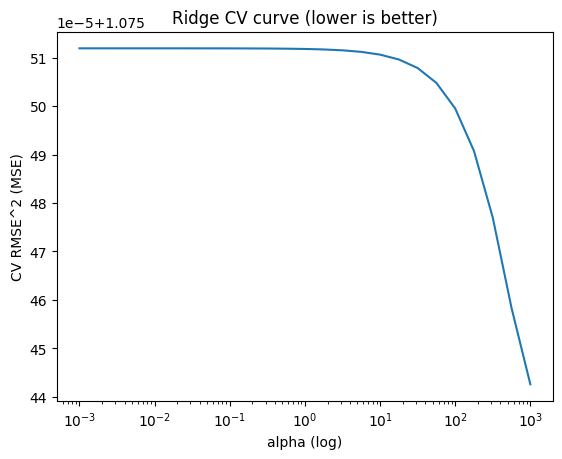

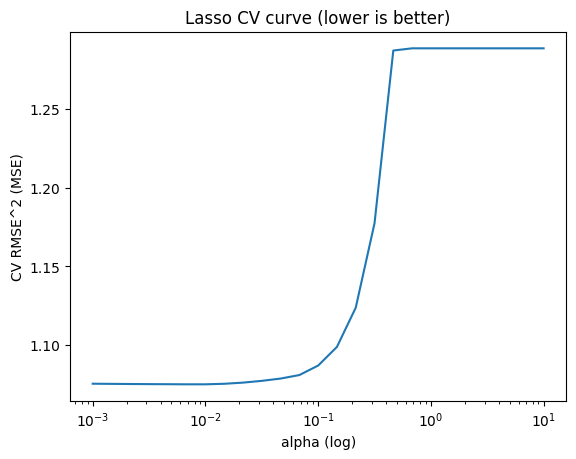

,model,train_RMSE,train_MAE,train_R2,test_RMSE,test_MAE,test_R2,n_nonzero
0,OLS,1.031534,0.825313,0.172681,0.988670,0.796635,0.184391,42
1,Ridge(alpha=1000),1.031551,0.825690,0.172654,0.988824,0.797091,0.184136,41
2,Lasso(alpha=0.006813),1.031977,0.826237,0.171970,0.988608,0.797266,0.184493,14


In [67]:
comparison_table = compare_regularization_methods(X_train, y_train, X_test, y_test, groups_train)
comparison_table


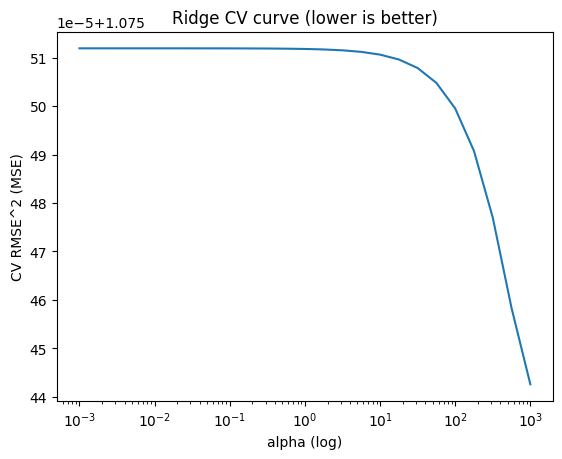

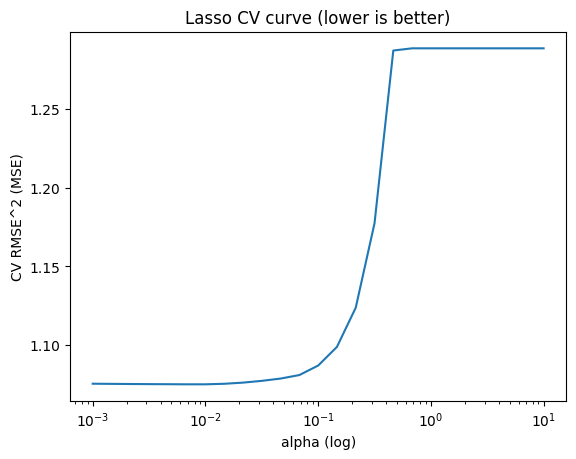

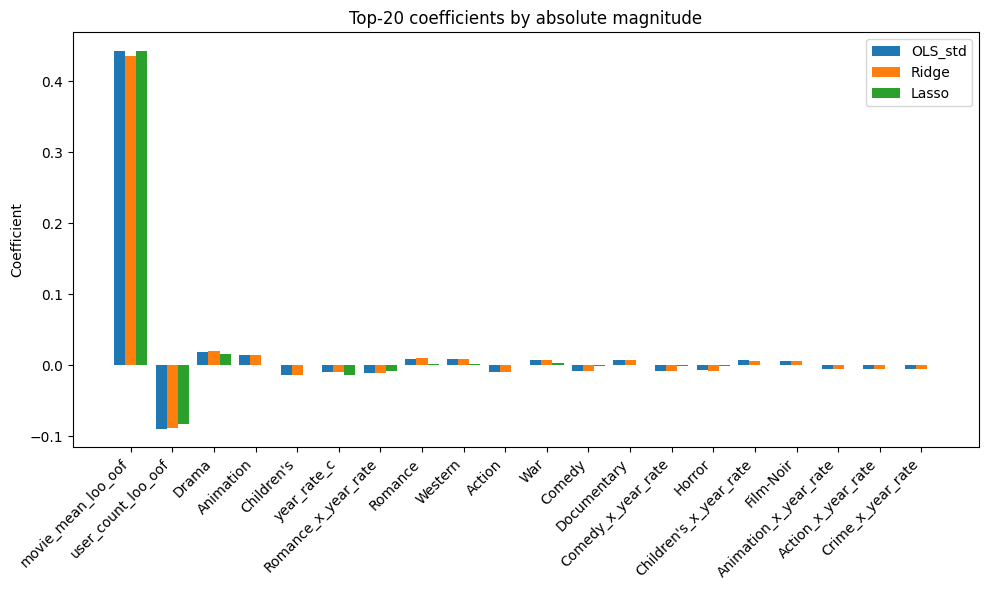

In [68]:
# Если ещё не обучали отдельно — обучим сейчас и сохраним best estimators
ridge_model, ridge_alphas, ridge_best_alpha, ridge_cv = fit_ridge_cv(
    X_train, y_train, groups=groups_train, alphas=None, cv=5, scoring="neg_mean_squared_error"
)

lasso_model, lasso_alphas, lasso_best_alpha, lasso_cv = fit_lasso_cv(
    X_train, y_train, groups=groups_train, alphas=None, cv=5, scoring="neg_mean_squared_error", max_iter=20000
)

# Стандартизованный OLS для сопоставимости шкал коэффициентов
ols_std_pipe = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())]).fit(X_train, y_train)

models_for_plot = {
    "OLS_std": ols_std_pipe.named_steps["lr"],                 # коэф. на стандартизованных фичах
    "Ridge":   ridge_model.named_steps["ridge"],               # уже стандартизованы в пайплайне
    "Lasso":   lasso_model.named_steps["lasso"],               # тоже
}

plot_coefficient_comparison(models_for_plot, feature_names=list(X_train.columns), top_n=20)


In [50]:
# =============================================================================
# МНОЖЕСТВЕННЫЕ СРАВНЕНИЯ И FDR-КОНТРОЛЬ
# =============================================================================

from typing import Dict, List, Optional, Tuple
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy.stats import t as t_dist
import matplotlib.pyplot as plt
import math

def apply_fdr_correction(
    pvalues: np.ndarray,
    alpha: float = 0.05,
    method: str = "fdr_bh"
) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Применить коррекцию FDR (Benjamini–Hochberg по умолчанию).
    Возвращает (mask_rejected, pvals_corrected, alpha_corr).
    """
    pvalues = np.asarray(pvalues)
    rej, p_corr, alpha_corr, _ = multipletests(pvalues, alpha=alpha, method=method)
    return rej, p_corr, alpha_corr


def test_coefficient_family(
    model: sm.regression.linear_model.RegressionResultsWrapper,
    family_indices: List[int],
    family_name: str,
    fdr_alpha: float = 0.05,
    method: str = "fdr_bh"
) -> pd.DataFrame:
    """
    FDR-контроль для семейства коэффициентов модели (по их p-values).
    family_indices — индексы в векторе params/pvalues модели.
    """
    terms = model.params.index.values
    fam_terms = terms[family_indices]
    fam_coefs = model.params.values[family_indices]
    fam_pvals = model.pvalues.values[family_indices]

    rej, p_corr, _ = apply_fdr_correction(fam_pvals, alpha=fdr_alpha, method=method)
    out = pd.DataFrame({
        "family": family_name,
        "term": fam_terms,
        "coef": fam_coefs,
        "p_raw": fam_pvals,
        "p_fdr": p_corr,
        "reject": rej
    }).sort_values("p_fdr").reset_index(drop=True)
    return out


def test_multiple_contrasts(
    model: sm.regression.linear_model.RegressionResultsWrapper,
    contrast_dict: Dict[str, np.ndarray],
    fdr_alpha: float = 0.05,
    method: str = "fdr_bh"
) -> pd.DataFrame:
    """
    Вычисляет p-values для набора линейных контрастов и применяет FDR-коррекцию.
    contrast_dict: {name: c_vector} где c имеет длину, равную числу параметров модели.
    """
    cov_beta = model.cov_params().values
    beta_hat = model.params.values
    df_resid = int(model.df_resid)

    names, estimates, ses, tstats, pvals = [], [], [], [], []
    for name, c in contrast_dict.items():
        c = np.asarray(c).reshape(-1)
        est = float(c @ beta_hat)
        se2 = float(c @ cov_beta @ c)
        se = math.sqrt(se2) if se2 > 0 else float("nan")
        t_stat = est / se
        p_val = 2 * t_dist.sf(abs(t_stat), df_resid)

        names.append(name); estimates.append(est); ses.append(se)
        tstats.append(t_stat); pvals.append(p_val)

    rej, p_corr, _ = apply_fdr_correction(np.array(pvals), alpha=fdr_alpha, method=method)

    res = pd.DataFrame({
        "contrast": names,
        "estimate": estimates,
        "SE": ses,
        "t": tstats,
        "p_raw": pvals,
        "p_fdr": p_corr,
        "reject": rej
    }).sort_values("p_fdr").reset_index(drop=True)
    return res


def visualize_multiple_testing_results(
    pvalues_raw: np.ndarray,
    pvalues_corrected: np.ndarray,
    rejected: np.ndarray,
    test_names: list,
    alpha: float = 0.05,
    scale: str = "auto"
) -> None:
    """
    Бар-чарт p-значений с опцией лог-шкалы.
    scale: "linear" | "log10" | "neglog10" | "auto"
    """
    pvalues_raw = np.asarray(pvalues_raw, dtype=float)
    pvalues_corrected = np.asarray(pvalues_corrected, dtype=float)
    rejected = np.asarray(rejected, dtype=bool)

    # сортируем по скорректированным p
    idx = np.argsort(pvalues_corrected)
    names = [test_names[i] for i in idx]
    p_raw = pvalues_raw[idx]
    p_corr = pvalues_corrected[idx]
    rej = rejected[idx]

    # если значения очень маленькие — показываем в -log10
    if scale == "auto":
        scale = "neglog10" if np.nanmin(p_corr) < 1e-3 else "linear"

    # преобразуем
    eps = 1e-300  # чтобы не было -inf
    if scale == "neglog10":
        y_raw = -np.log10(np.clip(p_raw, eps, 1.0))
        y_corr = -np.log10(np.clip(p_corr, eps, 1.0))
        thresh = -np.log10(alpha)
        y_label = r"$-\log_{10}(p)$"
    elif scale == "log10":
        y_raw = np.log10(np.clip(p_raw, eps, 1.0))
        y_corr = np.log10(np.clip(p_corr, eps, 1.0))
        thresh = np.log10(alpha)
        y_label = r"$\log_{10}(p)$"
    else:  # linear
        y_raw = p_raw
        y_corr = p_corr
        thresh = alpha
        y_label = "p-value"

    x = np.arange(len(names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(max(8, 1 + 0.6 * len(names)), 6))
    ax.bar(x - width/2, y_raw, width=width, label="p (raw)")
    ax.bar(x + width/2, y_corr, width=width, label="p (FDR)")

    # линия порога
    ax.axhline(thresh, linestyle="--", linewidth=1)

    # звездочки на значимых
    for i, r in enumerate(rej):
        if r:
            ax.text(x[i], y_corr[i], "*", ha="center", va="bottom")

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha="right")
    ax.set_ylabel(y_label)
    title_scale = {"neglog10":"(-log10 scale)","log10":"(log10 scale)","linear":"(linear)"}
    ax.set_title(f"Multiple testing with FDR correction {title_scale.get(scale,'')}")
    ax.legend()
    fig.tight_layout()
    plt.show()

In [69]:
# Возьмём p-values именно по жанрам из model_full (матричная модель).
genre_idx = [i for i, t in enumerate(model_full.params.index) if t in genre_cols]
fam_df = test_coefficient_family(model_full, genre_idx, family_name="genres", fdr_alpha=0.05)
fam_df.head(10)


,family,term,coef,p_raw,p_fdr,reject
0,genres,Drama,0.293536,4.556553e-201,8.657452e-200,True
1,genres,Animation,0.381575,1.510641e-58,1.435109e-57,True
2,genres,Children's,-0.260071,2.473358e-48,1.566460e-47,True
3,genres,War,0.170305,4.629637e-41,2.199077e-40,True
4,genres,Romance,0.120595,4.238773e-40,1.610734e-39,True
5,genres,Horror,-0.185848,5.026604e-30,1.591758e-29,True
6,genres,Crime,0.125864,1.978788e-21,5.370997e-21,True
7,genres,Documentary,0.383717,7.274645e-21,1.727728e-20,True
8,genres,Sci-Fi,0.104171,4.333543e-19,9.148591e-19,True
9,genres,Thriller,0.076950,2.211832e-14,4.202481e-14,True


In [70]:
terms = list(model_full.params.index)
def e(name):
    v = np.zeros(len(terms))
    v[terms.index(name)] = 1.0
    return v

contrast_dict = {
    "Drama_vs_Comedy": e("Drama") - e("Comedy"),
    "Animation_vs_Children": e("Animation") - e("Children's"),
    "Documentary_vs_Horror": e("Documentary") - e("Horror")
}
contr_df = test_multiple_contrasts(model_full, contrast_dict, fdr_alpha=0.05)
contr_df


,contrast,estimate,SE,t,p_raw,p_fdr,reject
0,Drama_vs_Comedy,0.295109,0.00921,32.040483,4.104132e-224,1.231239e-223,True
1,Animation_vs_Children,0.641646,0.03547,18.089645,5.031850e-73,7.547776e-73,True
2,Documentary_vs_Horror,0.569566,0.04287,13.285743,3.029972e-40,3.029972e-40,True


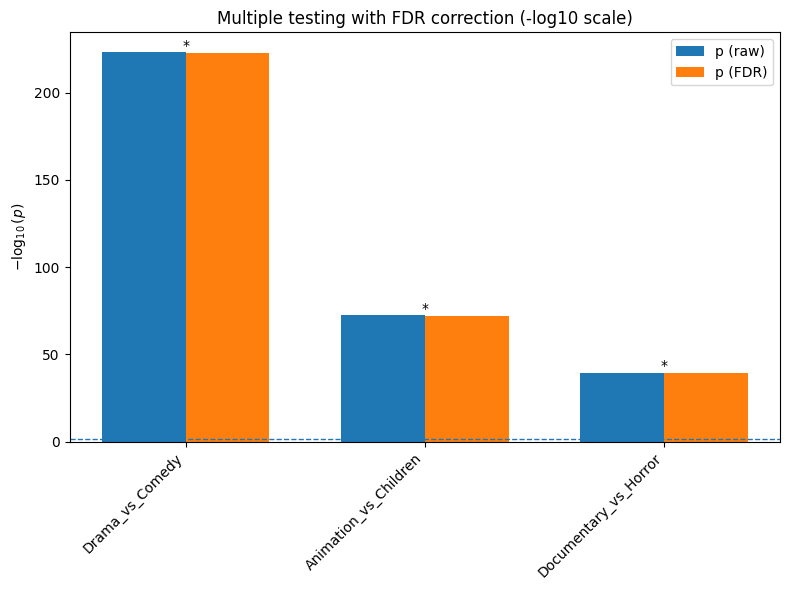

In [71]:
visualize_multiple_testing_results(
    pvalues_raw=contr_df["p_raw"].values,
    pvalues_corrected=contr_df["p_fdr"].values,
    rejected=contr_df["reject"].values,
    test_names=contr_df["contrast"].tolist(),
    alpha=0.05,
    scale="auto"   # можно "neglog10" принудительно
)

## БАЙЕСОВСКАЯ РЕГРЕССИЯ (PyMC)

In [96]:
from numpy.linalg import inv
from scipy.stats import invgamma, t as student_t

In [87]:
# =============================================================================
# БАЙЕСОВСКАЯ РЕГРЕССИЯ (PyMC)
# =============================================================================

In [93]:
num_cols = ["movie_mean_loo_oof", "user_count_loo_oof", "year_rate_c"]
from sklearn.preprocessing import StandardScaler
scaler_bayes = StandardScaler()
X_bayes_df = X_final.copy()
X_bayes_df[num_cols] = scaler_bayes.fit_transform(X_bayes_df[num_cols])

# В этой байес-модели перехват (alpha) учитываем как β_0, поэтому ДОБАВИМ константу в X:
X_bayes = np.column_stack([np.ones((X_bayes_df.shape[0], 1)), X_bayes_df.values])
y_bayes = y_final.astype(float)

feature_names_bayes = ["const"] + list(X_bayes_df.columns)
X_bayes.shape, y_bayes.shape, feature_names_bayes[:5]

((100000, 23),
 (100000,),
 ['const', 'unknown', 'Action', 'Adventure', 'Animation'])

In [94]:
def bayes_linear_conjugate_fit(
    X: np.ndarray,
    y: np.ndarray,
    tau2: float = 1.0,     # prior scale для β (аналог ridge; меньше tau2 -> сильнее shrinkage)
    a0: float = 1e-2,      # слабый априор на σ^2 ~ InvGamma(a0,b0)
    b0: float = 1e-2
) -> dict:
    X = np.asarray(X, float)
    y = np.asarray(y, float).reshape(-1)
    n, p = X.shape
    XtX = X.T @ X
    Xty = X.T @ y
    Vn = inv(XtX + (1.0 / tau2) * np.eye(p))
    mu_n = Vn @ Xty
    a_n = a0 + n / 2.0
    b_n = b0 + 0.5 * (float(y @ y) - float(mu_n @ Xty))
    return {"mu_n": mu_n, "Vn": Vn, "a_n": a_n, "b_n": b_n, "tau2": tau2, "p": p}

posterior = bayes_linear_conjugate_fit(X_bayes, y_bayes, tau2=1.0, a0=1e-2, b0=1e-2)
posterior.keys()


dict_keys(['mu_n', 'Vn', 'a_n', 'b_n', 'tau2', 'p'])

In [97]:
from numpy.random import default_rng

def sample_posterior_beta_sigma2(posterior: dict, n_draws: int = 4000, seed: int = 42):
    rng = default_rng(seed)
    mu_n, Vn, a_n, b_n = posterior["mu_n"], posterior["Vn"], posterior["a_n"], posterior["b_n"]
    sigma2_draws = invgamma(a=a_n, scale=b_n).rvs(size=n_draws, random_state=rng)
    beta_draws = np.empty((n_draws, len(mu_n)))
    for i in range(n_draws):
        beta_draws[i] = rng.multivariate_normal(mean=mu_n, cov=sigma2_draws[i] * Vn)
    return beta_draws, sigma2_draws

def predictive_params(posterior: dict, X_new: np.ndarray):
    mu_n, Vn, a_n, b_n = posterior["mu_n"], posterior["Vn"], posterior["a_n"], posterior["b_n"]
    X_new = np.asarray(X_new, float)
    mean = X_new @ mu_n
    var = (posterior["b_n"] / posterior["a_n"]) * (1.0 + np.einsum("ij,jk,ik->i", X_new, Vn, X_new))
    df = 2 * posterior["a_n"]
    return mean, var, df

beta_draws, sigma2_draws = sample_posterior_beta_sigma2(posterior, n_draws=4000, seed=7)
beta_draws.shape, sigma2_draws.shape


((4000, 23), (4000,))

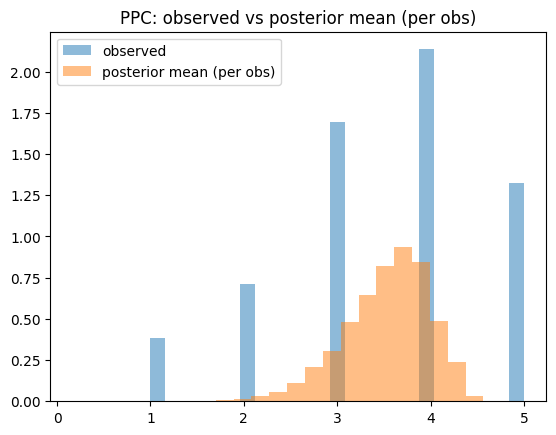

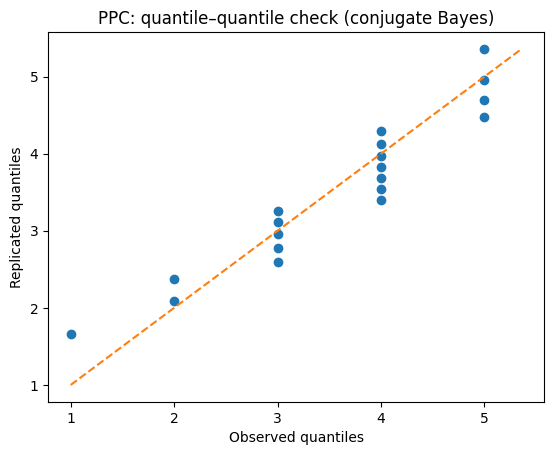

{'observed_mean': 3.52986, 'observed_std': 1.125673599144316, 'replicated_mean_mean': 3.5298233822369838, 'replicated_mean_std': 1.1258341247747445}


In [98]:
def ppc_closed_form(posterior: dict, X: np.ndarray, y_obs: np.ndarray, n_draws: int = 1000, seed: int = 0):
    rng = default_rng(seed)
    mean, var, df = predictive_params(posterior, X)
    scale = np.sqrt(var)
    y_rep = rng.standard_t(df, size=(n_draws, len(mean))) * scale + mean  # (n_draws, n_obs)

    # 1) Гистограммы
    fig, ax = plt.subplots()
    ax.hist(y_obs, bins=25, alpha=0.5, density=True, label="observed")
    ax.hist(y_rep.mean(axis=0), bins=25, alpha=0.5, density=True, label="posterior mean (per obs)")
    ax.set_title("PPC: observed vs posterior mean (per obs)")
    ax.legend()
    plt.show()

    # 2) Квантили (QQ-подобно)
    qs = np.linspace(0.05, 0.95, 19)
    y_q = np.quantile(y_obs, qs)
    yrep_q = np.quantile(y_rep, qs, axis=None)
    fig, ax = plt.subplots()
    ax.plot(y_q, yrep_q, "o")
    lims = [min(y_q.min(), yrep_q.min()), max(y_q.max(), yrep_q.max())]
    ax.plot(lims, lims, "--")
    ax.set_xlabel("Observed quantiles")
    ax.set_ylabel("Replicated quantiles")
    ax.set_title("PPC: quantile–quantile check (conjugate Bayes)")
    plt.show()

    stats = {
        "observed_mean": float(np.mean(y_obs)),
        "observed_std": float(np.std(y_obs, ddof=1)),
        "replicated_mean_mean": float(np.mean(y_rep)),
        "replicated_mean_std": float(np.std(y_rep, ddof=1)),
    }
    print(stats)
    return y_rep, stats

_ = ppc_closed_form(posterior, X_bayes, y_bayes, n_draws=1000, seed=1)


In [99]:
def posterior_intervals(beta_draws: np.ndarray, names: list[str], hdi: float = 0.95) -> pd.DataFrame:
    low_q = (1 - hdi) / 2
    hi_q  = 1 - low_q
    means = beta_draws.mean(axis=0)
    sds   = beta_draws.std(axis=0, ddof=1)
    lows  = np.quantile(beta_draws, low_q, axis=0)
    highs = np.quantile(beta_draws, hi_q,  axis=0)
    out = pd.DataFrame({"term": names, "mean": means, "sd": sds, f"low_{int(hdi*100)}": lows, f"high_{int(hdi*100)}": highs})
    return out

post_tbl = posterior_intervals(beta_draws, feature_names_bayes, hdi=0.95)
post_tbl.sort_values("mean", key=lambda s: s.abs(), ascending=False).head(15)


,term,mean,sd,low_95,high_95
0,const,3.512843,0.009905,3.493350,3.532189
1,unknown,-0.490356,0.307830,-1.082896,0.128900
20,movie_mean_loo_oof,0.447429,0.003558,0.440565,0.454389
8,Documentary,0.077991,0.038558,0.003351,0.151556
21,user_count_loo_oof,-0.071675,0.003235,-0.077874,-0.065280
4,Animation,0.063110,0.022325,0.019971,0.106871
19,Western,0.062518,0.024546,0.013619,0.109312
11,Film-Noir,0.053506,0.025932,0.002901,0.105249
5,Children's,-0.052759,0.016641,-0.085291,-0.020299
9,Drama,0.038057,0.009132,0.019688,0.056313


In [100]:
from scipy.stats import norm

def waic_from_draws(X: np.ndarray, y: np.ndarray, beta_draws: np.ndarray, sigma2_draws: np.ndarray) -> dict:
    """
    Считает WAIC по постериорным сэмплам (S, p) из β и σ².
    """
    S = beta_draws.shape[0]
    y = y.reshape(-1)
    mu_draws = X @ beta_draws.T                    # (n, S)
    sigma_draws = np.sqrt(sigma2_draws)[None, :]   # (1, S)

    # log-likelihood по наблюдениям и выборкам
    ll = norm.logpdf(y[:, None], loc=mu_draws, scale=sigma_draws)  # (n, S)
    # lppd
    lse = np.logaddexp.reduce(ll, axis=1) - np.log(S)              # log(mean_s p)
    lppd = np.sum(lse)
    # penalty
    pll = ll.mean(axis=1)                                          # mean_s log p
    p_waic = 2 * np.sum(lse - pll)
    waic = -2 * (lppd - p_waic)
    return {"WAIC": float(waic), "lppd": float(lppd), "p_waic": float(p_waic)}

waic_bayes = waic_from_draws(X_bayes, y_bayes, beta_draws, sigma2_draws)
waic_bayes


{'WAIC': 288234.4945226901,
 'lppd': -144092.07424187212,
 'p_waic': 25.173019472923315}

In [102]:
import statsmodels.formula.api as smf

# хелпер: обернуть имя признака для Patsy
def q(name: str) -> str:
    return f'Q("{name}")'

df_mixed = df_loo.copy()

# Строим формулу с экранированными именами (жанры + LOO + тренд)
fixed_terms = " + ".join(q(c) for c in X_final.columns)
formula = f"rating ~ {fixed_terms}"

# Перекрёстные случайные эффекты:
# основная группа = user_id, фильмы как variance component
vc = {"movie": "0 + C(movie_id)"}

mixed_model = smf.mixedlm(
    formula=formula,
    data=df_mixed,
    groups=df_mixed["user_id"],
    vc_formula=vc,
    re_formula="1"
)
mixed_res = mixed_model.fit(method="lbfgs", maxiter=200, disp=False)
print(mixed_res.summary())


               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    rating      
No. Observations:    100000     Method:                REML        
No. Groups:          943        Scale:                 0.3796      
Min. group size:     20         Log-Likelihood:        -137463.2331
Max. group size:     737        Converged:             Yes         
Mean group size:     106.0                                         
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                0.653    0.030  22.110 0.000  0.595  0.711
Q("unknown")            -0.351    0.300  -1.170 0.242 -0.939  0.237
Q("Action")             -0.025    0.009  -2.717 0.007 -0.043 -0.007
Q("Adventure")          -0.007    0.011  -0.660 0.509 -0.028  0.014
Q("Animation")           0.078    0.021   3.769 0.000  0.037  0

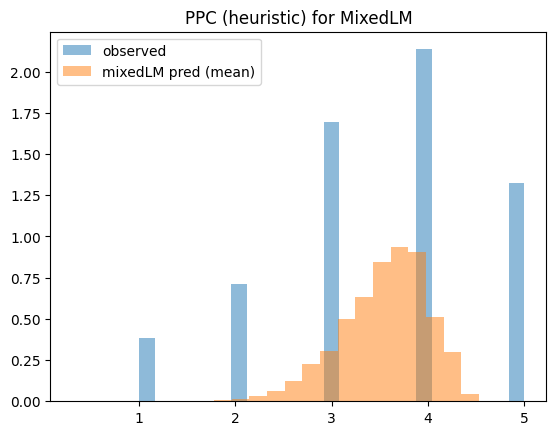

In [103]:
# Предсказания на тех же данных (или на hold-out, если сделаешь разбиение)
y_hat_mixed = mixed_res.predict(exog=df_mixed)

# Простейшая PPC: сравнение распределений предсказаний и наблюдений
fig, ax = plt.subplots()
ax.hist(df_mixed["rating"].values, bins=25, alpha=0.5, density=True, label="observed")
ax.hist(y_hat_mixed,            bins=25, alpha=0.5, density=True, label="mixedLM pred (mean)")
ax.set_title("PPC (heuristic) for MixedLM")
ax.legend()
plt.show()


## Ресемплинг: бутстреп-ДИ и перестановочные тесты

In [104]:
from typing import Dict, List, Tuple, Union, Callable
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, GroupKFold

In [106]:
def make_ols() -> LinearRegression:
    return LinearRegression(fit_intercept=True)

def make_ridge(alpha: float = None) -> Ridge:
    # если заранее подобранный alpha лежит в глобалах — используем его
    a = alpha if alpha is not None else globals().get("RIDGE_BEST_ALPHA", 1.0)
    return Ridge(alpha=a, fit_intercept=True, random_state=RANDOM_STATE)

def make_lasso(alpha: float = None, max_iter: int = 20000) -> Lasso:
    a = alpha if alpha is not None else globals().get("LASSO_BEST_ALPHA", 0.01)
    return Lasso(alpha=a, fit_intercept=True, max_iter=max_iter, random_state=RANDOM_STATE)

In [107]:
# =============================================================================
# 7. БУТСТРЕП
# =============================================================================

from numpy.random import default_rng

def bootstrap_metric(
    X: pd.DataFrame,
    y: np.ndarray,
    metric_func: Callable[[np.ndarray, np.ndarray], float],
    model_func: Callable[[], object] = make_ols,
    n_bootstrap: int = 1000,
    confidence_level: float = 0.95,
    random_state: int = RANDOM_STATE
) -> Dict[str, float]:
    """
    Бутстреп-ДИ для метрики на hold-in (fit+predict на бутстреп-выборке).
    Для корректности зависимостей по пользователю лучше кластерный бутстреп (ниже).
    """
    rng = default_rng(random_state)
    n = len(y)
    vals = np.empty(n_bootstrap, dtype=float)

    Xv = X.values if isinstance(X, pd.DataFrame) else X
    yv = np.asarray(y).reshape(-1)

    for b in range(n_bootstrap):
        idx = rng.integers(0, n, size=n)           # с возвращением
        model = model_func()
        model.fit(Xv[idx], yv[idx])
        y_pred = model.predict(Xv[idx])
        vals[b] = metric_func(yv[idx], y_pred)

    alpha = (1 - confidence_level) / 2
    lo, hi = np.quantile(vals, [alpha, 1 - alpha])
    res = {"mean": float(np.mean(vals)), "std": float(np.std(vals, ddof=1)),
           "CI_lower": float(lo), "CI_upper": float(hi)}
    # Визуализация
    plt.figure(figsize=(6,3.2))
    plt.hist(vals, bins=30, density=True)
    plt.axvline(lo, ls="--"); plt.axvline(hi, ls="--")
    plt.title(f"Bootstrap {metric_func.__name__} (percentile CI {confidence_level:.0%})")
    plt.show()
    return res

def bootstrap_metric_grouped(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str,
    group_col: str,
    metric_func: Callable[[np.ndarray, np.ndarray], float],
    model_func: Callable[[], object] = make_ols,
    n_bootstrap: int = 1000,
    confidence_level: float = 0.95,
    random_state: int = RANDOM_STATE
) -> Dict[str, float]:
    """
    Кластерный бутстреп по группам (напр., user_id): ресэмплируем группы с возвращением.
    Рекомендуется для рейтингов.
    """
    rng = default_rng(random_state)
    groups = df[group_col].unique()
    G = len(groups)
    vals = np.empty(n_bootstrap, dtype=float)

    for b in range(n_bootstrap):
        boot_groups = rng.choice(groups, size=G, replace=True)
        boot_idx = df[group_col].isin(boot_groups).values
        Xb = df.loc[boot_idx, feature_cols].values
        yb = df.loc[boot_idx, target_col].values
        model = model_func()
        model.fit(Xb, yb)
        y_pred = model.predict(Xb)
        vals[b] = metric_func(yb, y_pred)

    alpha = (1 - confidence_level) / 2
    lo, hi = np.quantile(vals, [alpha, 1 - alpha])
    res = {"mean": float(np.mean(vals)), "std": float(np.std(vals, ddof=1)),
           "CI_lower": float(lo), "CI_upper": float(hi)}
    plt.figure(figsize=(6,3.2))
    plt.hist(vals, bins=30, density=True)
    plt.axvline(lo, ls="--"); plt.axvline(hi, ls="--")
    plt.title(f"Cluster bootstrap {metric_func.__name__} by {group_col}")
    plt.show()
    return res


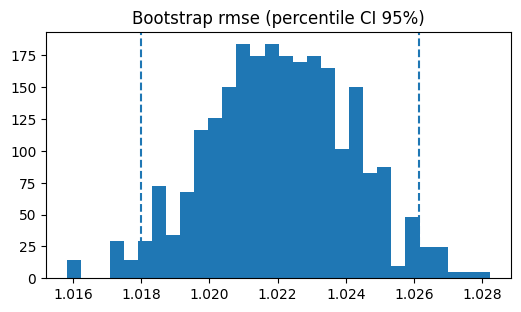

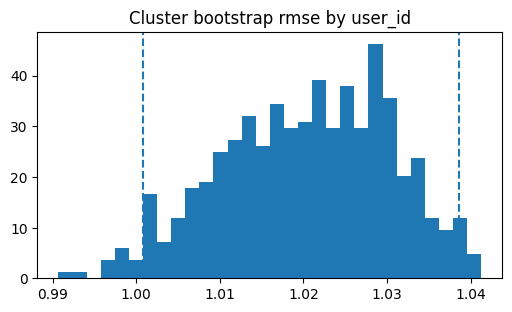

{'mean': 1.020380019473574,
 'std': 0.010049924161917332,
 'CI_lower': 1.0008058402569626,
 'CI_upper': 1.03856296634712}

In [108]:
# обычный бутстреп RMSE для OLS
boot_rmse = bootstrap_metric(X_final, y_final, metric_func=rmse, model_func=make_ols, n_bootstrap=500)
boot_rmse

# кластерный бутстреп RMSE по user_id (рекомендую для отчёта)
boot_rmse_user = bootstrap_metric_grouped(df_loo, list(X_final.columns), "rating", "user_id",
                                          metric_func=rmse, model_func=make_ols, n_bootstrap=500)
boot_rmse_user


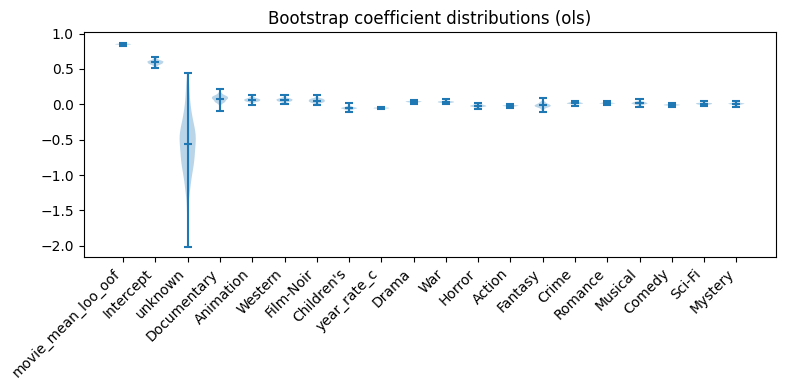

,term,coef_full,boot_mean,boot_sd,low_95,high_95
0,Intercept,0.595585,0.591988,0.029911,0.529792,0.648637
1,unknown,-0.538162,-0.565228,0.416784,-1.438397,0.294336
2,Action,-0.019089,-0.019445,0.009102,-0.035925,-0.001203
3,Adventure,0.003645,0.004034,0.011245,-0.018166,0.026372
4,Animation,0.063219,0.062179,0.022788,0.020622,0.107941
5,Children's,-0.052856,-0.052932,0.017788,-0.083253,-0.017269
6,Comedy,-0.008717,-0.007525,0.008858,-0.023488,0.010889
7,Crime,0.016809,0.016621,0.012101,-0.007202,0.039413
8,Documentary,0.078287,0.080289,0.046513,-0.012673,0.166900
9,Drama,0.037851,0.037843,0.009479,0.019777,0.054845


In [109]:
def _fit_and_get_coefs(model, X, y) -> np.ndarray:
    model.fit(X, y)
    if hasattr(model, "coef_"):
        coef = model.coef_.ravel()
        # добавим intercept в начало для удобства
        intercept = np.array([float(model.intercept_)]) if hasattr(model, "intercept_") else np.array([0.0])
        return np.concatenate([intercept, coef])
    raise ValueError("Model has no coef_")

def bootstrap_coefficients(
    X: pd.DataFrame,
    y: np.ndarray,
    n_bootstrap: int = 1000,
    confidence_level: float = 0.95,
    model_type: str = "ols"
) -> pd.DataFrame:
    Xv = X.values if isinstance(X, pd.DataFrame) else X
    yv = np.asarray(y).reshape(-1)

    if model_type == "ols":
        make_model = make_ols
    elif model_type == "ridge":
        make_model = make_ridge
    elif model_type == "lasso":
        make_model = make_lasso
    else:
        raise ValueError("model_type must be 'ols'|'ridge'|'lasso'")

    # оценка на полном наборе
    base = make_model()
    coefs_base = _fit_and_get_coefs(base, Xv, yv)

    rng = default_rng(RANDOM_STATE)
    B = np.empty((n_bootstrap, len(coefs_base)), dtype=float)
    n = len(yv)

    for b in range(n_bootstrap):
        idx = rng.integers(0, n, size=n)
        model = make_model()
        B[b] = _fit_and_get_coefs(model, Xv[idx], yv[idx])

    alpha = (1 - confidence_level) / 2
    low = np.quantile(B, alpha, axis=0)
    high = np.quantile(B, 1 - alpha, axis=0)
    mean = B.mean(axis=0)
    sd = B.std(axis=0, ddof=1)

    names = ["Intercept"] + list(X.columns)
    out = pd.DataFrame({"term": names, "coef_full": coefs_base, "boot_mean": mean, "boot_sd": sd,
                        f"low_{int(confidence_level*100)}": low, f"high_{int(confidence_level*100)}": high})
    # быстрая виолинка для топ-N по |coef|
    top = np.argsort(np.abs(coefs_base))[::-1][:min(20, len(names))]
    plt.figure(figsize=(8, 4))
    plt.violinplot([B[:, i] for i in top], showmeans=True)
    plt.xticks(np.arange(1, len(top)+1), [names[i] for i in top], rotation=45, ha="right")
    plt.title(f"Bootstrap coefficient distributions ({model_type})")
    plt.tight_layout(); plt.show()

    return out

# пример: ДИ для жанровых коэффициентов OLS
boot_coefs = bootstrap_coefficients(X_final, y_final, n_bootstrap=400, confidence_level=0.95, model_type="ols")
boot_coefs.head(10)


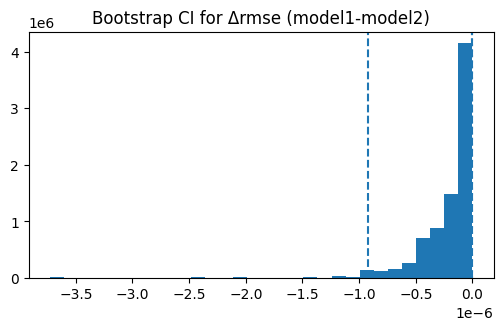

{'diff_mean': -2.2015344561254757e-07,
 'CI_lower': -9.247615625429527e-07,
 'CI_upper': -1.150535600125133e-09,
 'contains_zero': np.False_}

In [111]:
def bootstrap_model_comparison(
    X: pd.DataFrame,
    y: np.ndarray,
    model1_func: Callable[[], object],
    model2_func: Callable[[], object],
    metric_func: Callable[[np.ndarray, np.ndarray], float],
    n_bootstrap: int = 1000,
    confidence_level: float = 0.95
) -> Dict[str, Union[float, np.ndarray]]:
    rng = default_rng(RANDOM_STATE)
    Xv = X.values if isinstance(X, pd.DataFrame) else X
    yv = np.asarray(y).reshape(-1)
    n = len(yv)
    diffs = np.empty(n_bootstrap, dtype=float)

    for b in range(n_bootstrap):
        idx = rng.integers(0, n, size=n)
        m1, m2 = model1_func(), model2_func()
        m1.fit(Xv[idx], yv[idx]); m2.fit(Xv[idx], yv[idx])
        p1 = m1.predict(Xv[idx]);  p2 = m2.predict(Xv[idx])
        diffs[b] = metric_func(yv[idx], p1) - metric_func(yv[idx], p2)

    alpha = (1 - confidence_level) / 2
    lo, hi = np.quantile(diffs, [alpha, 1 - alpha])
    obs_mean = float(np.mean(diffs))
    contains_zero = lo <= 0.0 <= hi
    plt.figure(figsize=(6,3.2))
    plt.hist(diffs, bins=30, density=True)
    plt.axvline(lo, ls="--"); plt.axvline(hi, ls="--"); plt.axvline(0, ls=":")
    plt.title(f"Bootstrap CI for Δ{metric_func.__name__} (model1-model2)")
    plt.show()
    return {"diff_mean": obs_mean, "CI_lower": float(lo), "CI_upper": float(hi), "contains_zero": contains_zero}

# пример: разница RMSE(OLS) - RMSE(Ridge)
boot_cmp = bootstrap_model_comparison(X_final, y_final, make_ols, make_ridge, rmse, n_bootstrap=400)
boot_cmp


In [112]:
def permutation_test(
    X: pd.DataFrame,
    y: np.ndarray,
    test_statistic_func: Callable[[np.ndarray, np.ndarray], float],
    n_permutations: int = 1000,
    alternative: str = "two-sided",
    random_state: int = RANDOM_STATE
) -> Dict[str, Union[float, np.ndarray]]:
    """
    Стандартный перестановочный тест по перестановке y.
    test_statistic_func должен принимать (X, y) и возвращать число.
    """
    rng = default_rng(random_state)
    Xv = X.values if isinstance(X, pd.DataFrame) else X
    yv = np.asarray(y).reshape(-1)

    T_obs = float(test_statistic_func(Xv, yv))
    T_perm = np.empty(n_permutations, dtype=float)

    for b in range(n_permutations):
        y_perm = rng.permutation(yv)
        T_perm[b] = float(test_statistic_func(Xv, y_perm))

    if alternative == "two-sided":
        p_val = (1 + np.sum(np.abs(T_perm) >= abs(T_obs))) / (1 + n_permutations)
    elif alternative == "greater":
        p_val = (1 + np.sum(T_perm >= T_obs)) / (1 + n_permutations)
    else:
        p_val = (1 + np.sum(T_perm <= T_obs)) / (1 + n_permutations)

    plt.figure(figsize=(6,3.2))
    plt.hist(T_perm, bins=30, density=True)
    plt.axvline(T_obs, color="red", label="observed")
    plt.legend(); plt.title("Permutation null distribution")
    plt.show()

    return {"observed_statistic": T_obs, "p_value": float(p_val), "permuted_statistics": T_perm}


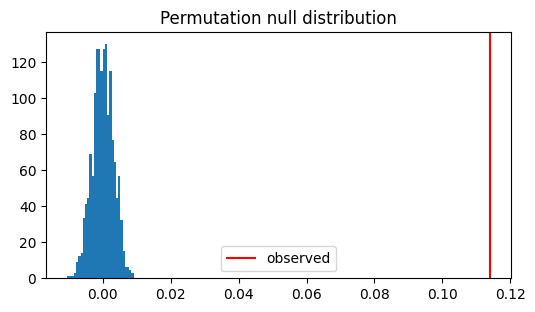

0.000999000999000999

In [113]:
def stat_corr_with_genre(X_arr, y_arr, col= list(X_final.columns).index("Drama")):
    return float(np.corrcoef(X_arr[:, col], y_arr)[0,1])

perm_res = permutation_test(X_final, y_final, lambda X,y: stat_corr_with_genre(X,y), n_permutations=1000)
perm_res["p_value"]


In [114]:
def cv_fold_rmse_differences(
    X: pd.DataFrame,
    y: np.ndarray,
    model1_func: Callable[[], object],
    model2_func: Callable[[], object],
    n_splits: int = 5,
    groups: np.ndarray | None = None
) -> np.ndarray:
    """
    Возвращает массив ΔRMSE по фолдам: RMSE(model1) - RMSE(model2).
    Если groups задан (например, user_id), используем GroupKFold.
    """
    Xv = X.values if isinstance(X, pd.DataFrame) else X
    yv = np.asarray(y).reshape(-1)

    if groups is not None:
        splitter = GroupKFold(n_splits=n_splits)
        splits = splitter.split(Xv, yv, groups=groups)
    else:
        splitter = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
        splits = splitter.split(Xv, yv)

    diffs = []
    for tr, te in splits:
        m1, m2 = model1_func(), model2_func()
        m1.fit(Xv[tr], yv[tr]); m2.fit(Xv[tr], yv[tr])
        p1 = m1.predict(Xv[te]); p2 = m2.predict(Xv[te])
        diffs.append(rmse(yv[te], p1) - rmse(yv[te], p2))
    return np.array(diffs, dtype=float)

def permutation_test_model_difference_signflip(
    X: pd.DataFrame,
    y: np.ndarray,
    model1_func: Callable[[], object],
    model2_func: Callable[[], object],
    n_permutations: int = 5000,
    n_splits: int = 5,
    groups: np.ndarray | None = None,
    random_state: int = RANDOM_STATE
) -> Dict[str, float]:
    """
    Перестановочный тест по знакам для ΔRMSE между двумя моделями:
    наблюдаемая статистика = средняя ΔRMSE по фолдам;
    нуль: симметрия вокруг 0 -> случайно флипуем знак каждой fold-Δ.
    """
    rng = default_rng(random_state)
    fold_diffs = cv_fold_rmse_differences(X, y, model1_func, model2_func, n_splits=n_splits, groups=groups)
    T_obs = float(np.mean(fold_diffs))
    T_perm = np.empty(n_permutations, dtype=float)

    for b in range(n_permutations):
        signs = rng.choice([-1, 1], size=fold_diffs.shape[0], replace=True)
        T_perm[b] = float(np.mean(fold_diffs * signs))

    p_val = (1 + np.sum(np.abs(T_perm) >= abs(T_obs))) / (1 + n_permutations)

    plt.figure(figsize=(6,3.2))
    plt.hist(T_perm, bins=30, density=True)
    plt.axvline(T_obs, color="red", label=f"obs mean ΔRMSE = {T_obs:.4f}")
    plt.legend(); plt.title("Permutation (sign-flip) null for ΔRMSE")
    plt.show()

    return {"observed_diff": T_obs, "p_value": float(p_val), "n_folds": int(len(fold_diffs))}


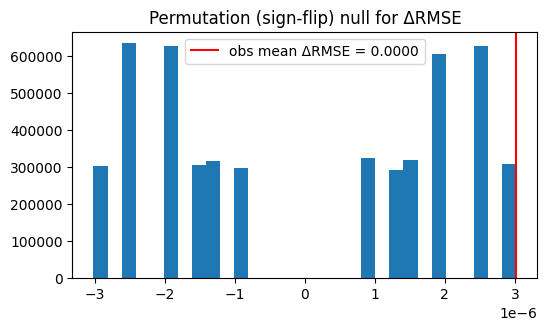

{'observed_diff': 3.019514587210281e-06,
 'p_value': 0.0619876024795041,
 'n_folds': 5}

In [115]:
perm_diff = permutation_test_model_difference_signflip(
    X_final, y_final, make_ols, make_ridge,
    n_permutations=5000, n_splits=5, groups=df_loo["user_id"].values
)
perm_diff


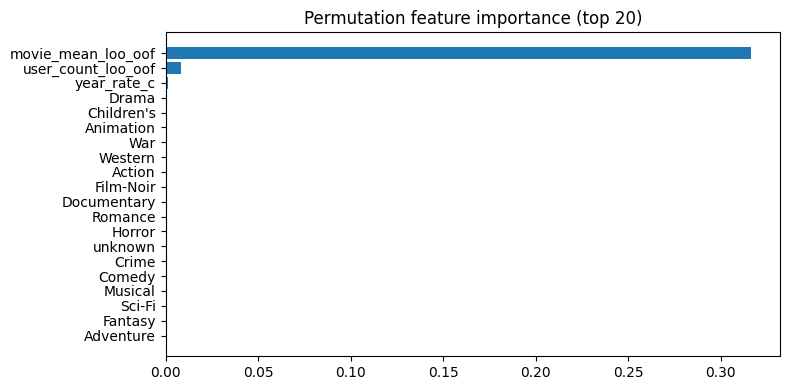

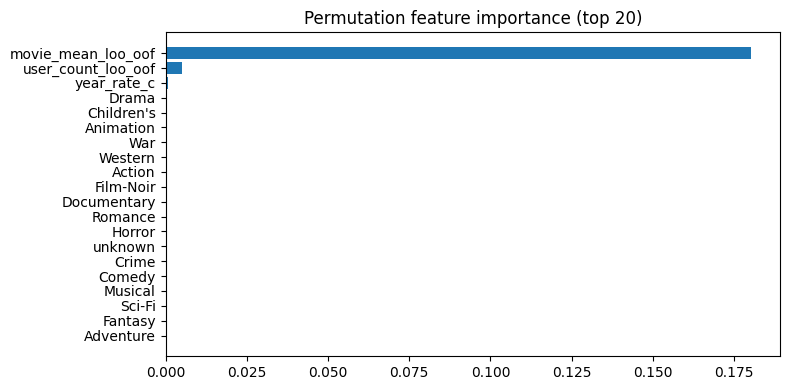

,feature,importance
19,movie_mean_loo_oof,0.180116
20,user_count_loo_oof,0.005007
21,year_rate_c,0.000653
8,Drama,0.000336
4,Children's,0.000181
3,Animation,0.000138
17,War,0.000089
18,Western,0.000069
1,Action,0.000065
10,Film-Noir,0.000050


In [116]:
def permutation_feature_importance(
    X: pd.DataFrame,
    y: np.ndarray,
    model_func: Callable[[], object],
    metric_func: Callable[[np.ndarray, np.ndarray], float],
    n_permutations: int = 100
) -> pd.DataFrame:
    """
    Важность = базовая метрика - метрика после перестановки столбца (чем больше — тем важнее).
    ВАЖНО: metric_func должен быть «чем выше, тем лучше».
           Для RMSE используй lambda y, p: -rmse(y,p), чтобы превратить в «чем выше, тем лучше».
    """
    Xdf = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
    yv = np.asarray(y).reshape(-1)

    # базовая модель и метрика (на hold-in)
    base_model = model_func()
    base_model.fit(Xdf.values, yv)
    base_pred = base_model.predict(Xdf.values)
    base_metric = metric_func(yv, base_pred)

    rng = default_rng(RANDOM_STATE)
    drops = []
    for col in Xdf.columns:
        scores = np.empty(n_permutations, dtype=float)
        for b in range(n_permutations):
            Xp = Xdf.values.copy()
            Xp[:, Xdf.columns.get_loc(col)] = rng.permutation(Xp[:, Xdf.columns.get_loc(col)])
            pred = base_model.predict(Xp)
            scores[b] = metric_func(yv, pred)
        drops.append(base_metric - np.mean(scores))

    imp = pd.DataFrame({"feature": Xdf.columns, "importance": drops}).sort_values("importance", ascending=False)

    plt.figure(figsize=(8,4))
    plt.barh(imp["feature"].head(20)[::-1], imp["importance"].head(20)[::-1])
    plt.title("Permutation feature importance (top 20)")
    plt.tight_layout(); plt.show()
    return imp

# пример: важность для OLS, метрика — R² (выше лучше)
imp_r2 = permutation_feature_importance(X_final, y_final, make_ols, metric_func=r2, n_permutations=100)
imp_r2.head(10)

# пример для RMSE: используем «-RMSE», чтобы «выше = лучше»
imp_neg_rmse = permutation_feature_importance(X_final, y_final, make_ols, metric_func=lambda y,p: -rmse(y,p), n_permutations=100)
imp_neg_rmse.head(10)
